# Braket module in Tequila

Hi! This is a tutorial to get to know the new Tequila's function: `braket`. With this new function you will be able to easily compute:

1. self overlaps;
2. overlaps between two different states;
3. the expectation value of an operator;
4. the transition element of an operator.

So, let's import Tequila (and some of its modules) and see how this function works.

In [17]:
#tequila importations
import tequila as tq
from tequila.circuit.gates import H, X, Rx, CX
from tequila.hamiltonian.qubit_hamiltonian import QubitHamiltonian

#extra importations
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Basic usage

### 1. Self overlap

Let's begin from the simplest (and maybe trivial) possible application of the `braket` function: the computation of the self overlap of a quantum state. One can prepare an aritrary circuit, corresponding to the state $|\psi\rangle$ and then calculate the self overlap: $\langle \psi|\psi\rangle$. 

We can prepare for example a Bell state of two qubits:

In [10]:
bell = tq.QCircuit()
bell += H(0)
bell += CX(0,1)

tq.draw(bell, backend='qiskit')

┌───┐     
q_0: ┤ H ├──■──
     └───┘┌─┴─┐
q_1: ─────┤ X ├
          └───┘
c: 2/══════════

Then, we can simply call the `braket` function passing as unique argument our quantum circuit, this can also be specified as `ket`:

In [11]:
self_overlap_real, self_overlap_im = tq.braket(ket=bell)
#joining real and imaginary part
self_overlap = self_overlap_real + 1.0j*self_overlap_im

As we have seen the braket function always return two objects, one for the real part and one for the imaginary one. These are `tq.Objecitve` and need to be simulated in order to obtain a numeric value.

Of course, from the laws of quantum mechanics it follows that the self overlap must always be equal to 1, namely $\langle \psi|\psi\rangle=1$.

In [14]:
self_overlap_value = tq.simulate(self_overlap)
self_overlap_value

1.0

In this particular case Tequila is aware that the self overlap is always 1, so no circuit needs to be executed. This can be checked by printing the `self_overlap` Objective:

In [13]:
print(self_overlap)

Objective with 0 unique expectation values
total measurements = 0
variables          = []
types              = []


### 2. Overlap between two different states

The second step will be to compute the overlap between different states $\langle\psi _2|\psi _1\rangle$. Even in this case we can exploit the `braket` function.

Let's prepare two orthogonal states. In this case the overlap must be equal to 0:


In [15]:
U0 = X(0) # state |10>
U1 = H(0)+CX(0,1) # Bell state 1/sqrt(2)*(|00>+|11>)


Now, we can call the `braket` function passing as arguments our quantum circuits, specifying which will be the `ket` and which the `bra`.
Otherwise the first will be automatically selected as `ket` and second as `bra`:

In [16]:
br_objective_real, br_objective_im = tq.braket(ket=U0, bra=U1)

#joining real and imaginary part
br_overlap = br_objective_real + 1.0j*br_objective_im
# let's simulate the Objective
br_overlap_value = tq.simulate(br_overlap)

br_overlap_value

0.0

We can also define a non-orthogonal state with respect to the previous prepared Bell state. This can be obtained for example by preparing a Bell state followed by a rotation around X-axis. 

One can then check that changing the angle value will result in changing the overlap between the two states:

Text(0, 0.5, 'Overlap')

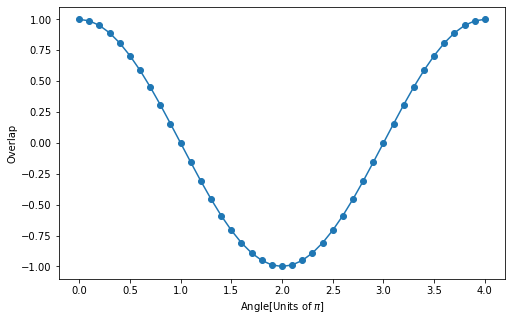

In [26]:
angle = tq.Variable("angle")
U2 = U1 + Rx(angle*np.pi, 1) # Bell state followed by a rotation around X-axis

br_objective_real, br_objective_im = tq.braket(ket=U1, bra=U2)
br_overlap = br_objective_real + 1.0j*br_objective_im
S = tq.compile(br_overlap) # translate to backend

overlaps = []
for value in np.arange(0,4.1, 0.1): 
# set the value we want to simulate
    variables = {"angle" : value}
    # let's simulate the Objective
    br_overlap_value = S(variables=variables)
    overlaps.append(round(br_overlap_value,3))

#plotting the trend
fig = plt.figure(figsize=(8,5))

plt.plot(np.arange(0,4.1, 0.1), overlaps, marker = 'o')
plt.xlabel(r'Angle[Units of $\pi$]')
plt.ylabel('Overlap')

### 3. Expectation value of an Hamiltonian

At this stage, we can see how to use the `braket` function to calculate the expectation value of an Hamiltonian $H$ with respect to a given state $|\psi\rangle$.

In [31]:
# state definition
psi = H(0)+CX(0,1) # Bell state 1/sqrt(2)*(|00>+|11>)

#Hamiltonian definition
operator = QubitHamiltonian.from_string("-1.0*X(0)X(1)")

Now, one needs to pass to the `braket` function as `ket` argument our state and as `operator` argument the Hamiltonian.
As already seen before, always keep in mind that the `braket` function returns two Objecitves that need to be compiled afterwards. 

With previous defined state and Hamiltonian we need to obtain an expectation value equal to $-1$.

In [32]:
#applying braket function
br_exp_value_real, br_exp_value_im = tq.braket(ket=psi, operator=operator)
#joining real and imaginary part
br_exp_value_tmp = br_exp_value_real + 1.0j*br_exp_value_im
#simulate the expectation value
br_exp_value = tq.simulate(br_exp_value_tmp)
br_exp_value

-1.0

Tequila is aware that an `ExpectationValue` is always real, so for the imaginary part no circuit needs to be executed. One can see this by printting `br_exp_value_im`:

In [33]:
print(br_exp_value_im)

Objective with 0 unique expectation values
total measurements = 0
variables          = []
types              = []


### 4. Transition element of an Hamiltonian

As last application, the `braket` function can be used to calculate transition elements of an operator $H$ with respect to two different states $|\alpha\rangle, \ |\beta\rangle$: $\langle\beta|H|\alpha\rangle$.

In order to see how things can change, we can procede similarly to section 2 and vary the angle of a rotation:  

In [41]:
#states definition
alpha = H(0)+CX(0,1) # Bell state 1/sqrt(2)*(|00>+|11>)
angle = tq.Variable("angle")
beta = alpha + Rx(angle*np.pi, 1) # Bell state followed by a rotation around X-axis

#Hamiltonian definition
operator = QubitHamiltonian("-1.0*X(0)X(1)")

br_trans_real, br_trans_im = tq.braket(ket=alpha, bra=beta, operator=operator)
br_trans_el = br_trans_real + 1.0j*br_trans_im
H_ab = tq.compile(br_trans_el) # transalte to backend

transitions = []
for value in np.arange(0,4.1, 0.1): 
    # set the value we want to simulate
    variables = {"angle" : value}
    br_trans_value = H_ab(variables=variables)
    transitions.append(round(br_trans_value,3))

Text(0, 0.5, 'Transitions')

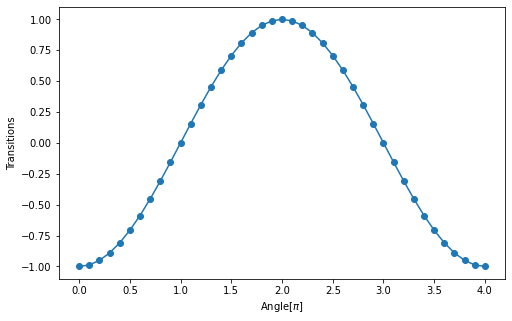

In [42]:
#plotting the trend
fig = plt.figure(figsize=(8,5))
plt.plot(np.arange(0,4.1, 0.1), transitions, marker = 'o')
plt.xlabel(r'Angle[$\pi$]')
plt.ylabel('Transitions')

Even in this particular case the imaginary part is 0 (as for an `ExpectationValue`), but in this case this happens because the wave functions are real. The difference can be noticed again by printing `br_trans_im` where in this case there is one circuit to be executed:

In [43]:
print(br_trans_im)

Objective with 1 unique expectation values
total measurements = 1
variables          = [angle]
types              = not compiled


In the end, we can address one small example in which the imaginary part is not 0. We have:

$$|\psi_0\rangle=R_x(a)\rvert  0 \rangle = \cos(a/2) \rvert 0 \rangle - i\sin(a/2)\rvert 1\rangle \quad , \quad |\psi_1\rangle=R_y(b)\rvert  0 \rangle = \cos(b/2) \rvert 0 \rangle + \sin(b/2)\rvert 1\rangle$$ 
and so the imaginary part of the transition amplitude comes down to $\text{Im}(\langle\psi_1|Z|\psi_0\rangle ) = -\sin(a/2)\sin(b/2)$ .

In [52]:
#states definition
a = tq.Variable("a")
b = 1

U0 = tq.gates.Rx(a*np.pi,0)
U1 = tq.gates.Ry(b*np.pi,0)

#Hamiltonian definition
operator = QubitHamiltonian("1.0*Z(0)")

br_trans_real, br_trans_im = tq.braket(ket=U0, bra=U1, operator=operator)

H_i = tq.compile(br_trans_im) # transalte to backend

transitions = []
for a in np.arange(0,4.1, 0.1): 
    # set the value we want to simulate
    variables = {"a" : a}
    br_trans_value = H_i(variables=variables)
    transitions.append(round(br_trans_value,3))

Text(0, 0.5, 'Transitions')

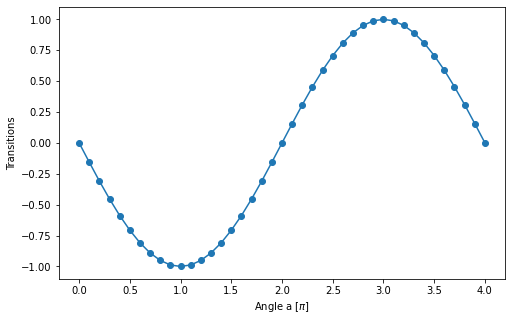

In [53]:
#plotting the trend
fig = plt.figure(figsize=(8,5))
plt.plot(np.arange(0,4.1, 0.1), transitions, marker = 'o')
plt.xlabel(r'Angle a [$\pi$]')
plt.ylabel('Transitions')

## Detailed explanation of internal `braket` structure

Let's give some insight about the underlying structure of `braket`.
This function in general just calls other functions to do all the different tasks one may need.

More in detail, the function acts as follows:

- If only ket is passed, `braket` directly returns the real and imaginary part of the self-overlap as `Objective()`. This is required since one may combine the different `braket` modalities and this will require the compilation of an `Objective()`.
- If ket and operator are passed, `braket` returns the `ExpectationValue` of the operator for the given state.
- If ket and bra are passed, `braket` returns the overlap between the two states. This is done by calling a new Tequila's function called `make_overlap`. Here below, we describe also how this function works.
- If ket, bra and operator are passed, `braket` returns the transition element of the operator by calling another new Tequila's function called `make_transition`. Even in this case we provide a description of the internal structure.

#### `Make_overlap` and `make_transition`

The `make_overlap` function constructs the following circuit that is able to calculate the overlap between two states of $n$ qubits. 

<p align='center'>
<img src="overlap_circuit.png" alt="overlap circ" width="500"/>
</p>

Here, $U_0$ and $U_1$ are two unitaries such that: 

$$U_0 |0\rangle^n=|\psi _ 0 \rangle \quad , \quad U_1 |0\rangle^n=|\psi _ 1 \rangle$$ 

so the circuit prepares the state:

$$ \frac{1}{\sqrt{2}}(|\psi _ 0 \rangle|0\rangle+|\psi _ 1 \rangle|1\rangle) \quad .$$

In the end measuring the ancilla in the $2\sigma_+$ base, gives as output:

$$^n\langle 0|U_ 0 ^\dagger U_1 |0\rangle^n=\langle\psi _ 0 |\psi _ 1 \rangle \quad .$$

We can check the circuit build by the `braket` function with the code contained in the next cell:

In [16]:
U0 = X(0) # state |10>
U1 = H(0)+CX(0,1) # Bell state 1/sqrt(2)*(|00>+|11>)

br_objective_real, br_objective_im = tq.braket(ket=U1, bra=U0) #consistently with the explained notation

tq.draw(br_objective_real)


Objective with 1 unique expectation values
total measurements = 1
variables          = []
types              = not compiled

Expectation Value 0:
total measurements = 1
variables          = 0
circuit            = 5588029959664042738_0.png
0: ───────X───────H───@───
          │       │   │
1: ───────┼───────┼───X───
          │       │   │
2: ───H───@───X───@───@───


As we can see, one ancilla qubit has been added to our quantum register to be used as control qubit. The two circuits have been controlled and applied with the correct structure: the ancilla has an $H$ gate allowing superposition, the $U_0$ is performed when the ancilla is in state $|0\rangle$ and the $U_1$ when the ancilla is in state $|1\rangle$. This circuit will be then measured in the $X$ and $Y$ basis to obtain, respectively, the real and the imaginary part $(2\sigma_+=X+iY)$.

For what concerns `make_transition` function, this exploits `make_overlap` to calculate multiple contributes of Pauli strings within an Hamiltonian operator. More in detail, suppose we have an Hamiltonian $H$ that can be decomposed as:

$$H = \sum_k c_k P_k$$

where $P_k$ are Pauli strings (tensor product of Pauli operators acting on different qubits). Then, in order to calcuate the transition element, we can compute the single contributions and sum them up:

$$\langle\psi _ 0 | H |\psi _ 1 \rangle = \sum_k c_k \langle\psi _ 0 | P_k |\psi _ 1 \rangle \quad .$$

Each of these contributions can be obtained from `make_overlap` by appending to the $U_1$ circuit the one that implements the Pauli string:
$$\langle\psi _ 0 | H |\psi _ 1 \rangle = \sum_k c_k \langle\psi _ 0 | P_k \psi _ 1 \rangle \quad .$$



In [18]:
U0 = X(0) # state |10>
U1 = H(0)+CX(0,1) # Bell state 1/sqrt(2)*(|00>+|11>)

#Hamiltonian definition
operator = QubitHamiltonian("-1.0*X(0)X(1)+0.5*Z(0)")

br_trans_real, br_trans_im = tq.braket(ket=U1, bra=U0, operator=operator) #consistently with the explained notation

tq.draw(br_trans_real)

Objective with 2 unique expectation values
total measurements = 2
variables          = []
types              = not compiled

Expectation Value 0:
total measurements = 1
variables          = 0
circuit            = 5588029959664042738_0.png
0: ───────X───────H───@───X───────
          │       │   │   │
1: ───────┼───────┼───X───┼───X───
          │       │   │   │   │
2: ───H───@───X───@───@───@───@───

Expectation Value 1:
total measurements = 1
variables          = 0
circuit            = 5588029959664042738_1.png
0: ───────X───────H───@───@───
          │       │   │   │
1: ───────┼───────┼───X───┼───
          │       │   │   │
2: ───H───@───X───@───@───@───


We can see that both `br_trans_real` and ` br_trans_im` contain in this case 2 circuits with the same gates in the first part of the circuit, but different gates corresponding to the Pauli operators in the Pauli strings.

These two functions were designed according to "N. H. Stair *et al.* - A Multireference Quantum Krylov Algorithm for Strongly Correlated Electrons" - [arXiv:1911.05163v1](https://arxiv.org/abs/1911.05163), [published paper](https://pubs.acs.org/doi/10.1021/acs.jctc.9b01125).

**ATTENTION**: In the attached ArXiv paper there is a missing $X$ gate before the control of $U_\alpha$ in Figure 2. This has been fixed in the published paper.